In [95]:
%%capture
%pip install ipython pandas matplotlib ipywidgets pillow

In [96]:
from io import BytesIO
import math as m

import pandas as pd
import numpy as np
import ipywidgets as widgets
from PIL import Image
import matplotlib.pyplot as plt

pd.options.display.precision = 2

In [97]:
STEP_FACTOR = 2 ** (1 / 2)
MIN_ZOOM = 0.8
IMAGE_PATH = "sigrid_rollo.jpg"
ZOOM_STEPS = [1, 2, 4, 6, 8]

Calculate the zoom for a given step:
* zoom: $z$
* step: $s$
* STEP_FACTOR: $f$

$$
  z = f ^ s
$$
$$
  \ln{z} = s \ln{f}
$$
$$
  s = \frac{\ln{z}}{\ln{f}}
$$

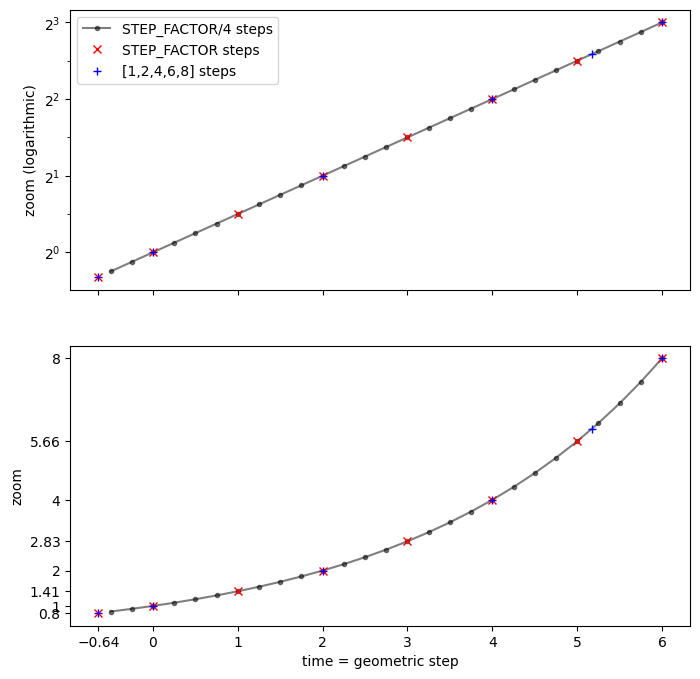

In [98]:
min_zoom_step = m.log(MIN_ZOOM) / m.log(STEP_FACTOR)

extra_zoom_steps = [m.log(zoom) / m.log(STEP_FACTOR) for zoom in ZOOM_STEPS]

steps = pd.Series(
    STEP_FACTOR ** (index := np.array([min_zoom_step] + list(range(7)))),
    index,
)

steps_man = pd.Series(
    STEP_FACTOR ** (index := np.array([min_zoom_step] + extra_zoom_steps)),
    index,
)

cont = pd.Series(
    STEP_FACTOR
    ** (index := np.arange(steps.index[-1], steps.index[0] + 0.001, -1 / 4)),
    index,
)

fig, (ax_log, ax_lin) = plt.subplots(2, 1, sharex=True, figsize=[8, 8])
ax_log.set_ylabel("zoom (logarithmic)")
ax_log.set_yscale("log", base=2, subs=[2**0.5])
ax_lin.set_ylabel("zoom")
ax_lin.yaxis.set_major_formatter("{x:.3g}")
ax_lin.set_yticks(steps.values)

for ax, logy in [(ax_log, True), (ax_lin, False)]:
    ax.set_xlabel("time = geometric step")
    ax.set_xticks(steps.index)
    ax.xaxis.set_major_formatter("{x:.2g}")

    cont.plot(style="k.-", alpha=0.5, ax=ax, label="STEP_FACTOR/4 steps")

    steps.plot(style="rx", ax=ax, label="STEP_FACTOR steps")

    steps_man.plot(style="b+", ax=ax, label="[1,2,4,6,8] steps")

ax_log.legend()
pass

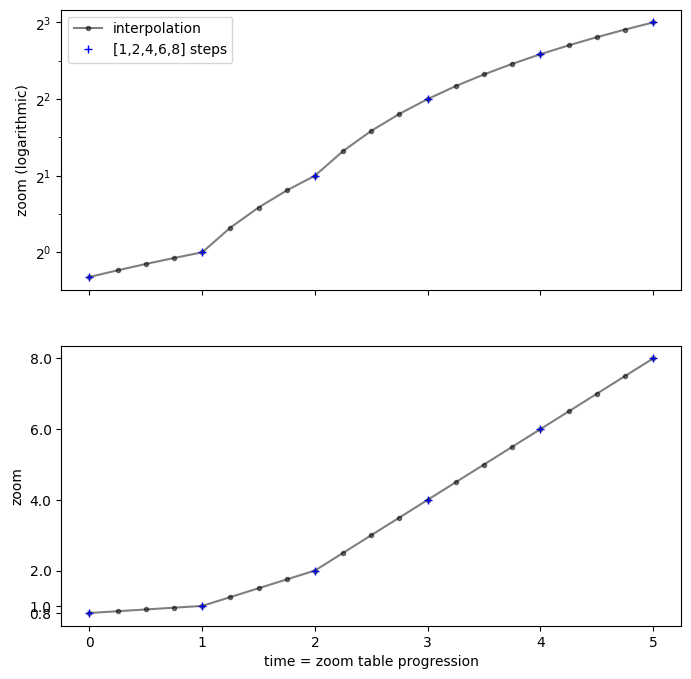

In [99]:
g_steps = pd.Series([MIN_ZOOM, 1, 2, 4, 6, 8])
g_scale = np.arange(0, len(g_steps) - 1 + 0.001, 1 / 4)
g = pd.Series(np.interp(g_scale, g_steps.index, g_steps.values), g_scale)

fig, (ax_log, ax_lin) = plt.subplots(2, 1, sharex=True, figsize=[8, 8])
ax_log.set_ylabel("zoom (logarithmic)")
ax_log.set_yscale("log", base=2, subs=[2**0.5])
ax_lin.set_ylabel("zoom")
# ax_lin.yaxis.set_major_formatter("{x:.3g}")
ax_lin.set_yticks(g_steps.values)

for ax, logy in [(ax_log, True), (ax_lin, False)]:
    ax.set_xlabel("time = zoom table progression")
    ax.set_xticks(g_steps.index)
    ax.xaxis.set_major_formatter("{x:.2g}")

    g.plot(style="k.-", alpha=0.5, ax=ax, label="interpolation")

    g_steps.plot(style="b+", ax=ax, label="[1,2,4,6,8] steps")

ax_log.legend()
pass

In [100]:
im = Image.open(IMAGE_PATH)

w_zoomed = widgets.Image(
    layout=widgets.Layout(width="640px"),
)

w_step = widgets.FloatSlider(
    description="step",
    value=0.0,
    min=steps.index[0],
    max=steps.index[-1],
    step=0.01,
    layout=widgets.Layout(width="640px"),
)
w_zoom = widgets.FloatSlider(
    description="zoom",
    value=1.0,
    min=steps.values[0],
    max=steps.values[-1],
    step=0.01,
    layout=widgets.Layout(width="640px"),
)


def set_step(step=0.0):
    scale = STEP_FACTOR ** (step - steps.index[0])
    size0 = np.array(im.size)
    size1 = size0 / scale
    corners = size0 / 2 + size1 / 2 * np.array([[-1], [1]])
    zoomed = im.crop(corners.flatten().tolist()).resize(size0)
    b = BytesIO()
    zoomed.save(b, "png")
    return b.getvalue()


widgets.dlink(
    (w_step, "value"),
    (w_zoomed, "value"),
    set_step,
)

widgets.link(
    (w_step, "value"),
    (w_zoom, "value"),
    (lambda step: STEP_FACTOR**step, lambda zoom: m.log(zoom) / m.log(STEP_FACTOR)),
)

widgets.VBox([w_zoomed, w_zoom, w_step])